In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data_folder = "/kaggle/input/g-research-crypto-forecasting/"

In [ ]:
crypto_df = pd.read_csv(data_folder + 'train.csv')

In [ ]:
crypto_df.head(10)

# Exploratory Data Analysis

The test data is contained in the original train data , so the LB score of 0.313 is overfitting.

For more information:
* __[Watch out!: test LB period is contained in the train csv](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285505) (topic)__
* __[G-Research- Using the overlap fully [LB=0.99]](https://www.kaggle.com/julian3833/g-research-using-the-overlap-fully-lb-0-99) (notebook)__
* __[Meaningful submission scores / sharing the lower boundary of public test data](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285289) (topic)__


So we need to check and exclude the test data from the train data

In [ ]:
test_df = pd.read_csv(data_folder + 'example_test.csv')
test_df.head(10)

In [ ]:
#Before excluding test data
print ("ACTUAL TRAIN DATA")

print ("Time stamp the train data set ends to: "+ str(pd.to_datetime(crypto_df['timestamp'], unit='s').min()))
print ("Time stamp the train data set ends to: "+ str(pd.to_datetime(crypto_df['timestamp'], unit='s').max()), end='\n\n')

print ("TEST DATA")

print ("Time stamp the test data set starts from: "+ str(pd.to_datetime(test_df['timestamp'], unit='s').min()))
print ("Time stamp the test data set ends to: "+ str(pd.to_datetime(test_df['timestamp'], unit='s').max()), end='\n\n')

Now this symbolize the test data is part of train data set.
So we need to exclude data from train dataset on after 2021-06-13 00:00:00

In [ ]:
if True:
    crypto_df_train = crypto_df[crypto_df['timestamp'] < test_df['timestamp'].min()]

In [ ]:
print ("ACTUAL TRAIN DATA")
print ("Time stamp the actual train data set starts from: "+ str(pd.to_datetime(crypto_df['timestamp'], unit='s').min()))
print ("Time stamp the actual train data set ends to: "+ str(pd.to_datetime(crypto_df['timestamp'], unit='s').max()), end='\n\n')
print ("DERIVED TRAIN DATA")
print ("Time stamp the derived train data set starts from: "+ str(pd.to_datetime(crypto_df_train['timestamp'], unit='s').min()))
print ("Time stamp the derived train data set ends to: "+ str(pd.to_datetime(crypto_df_train['timestamp'], unit='s').max()), end = '\n\n')
print ("TEST DATA")
print ("Time stamp the test data set starts from: "+ str(pd.to_datetime(test_df['timestamp'], unit='s').min()))
print ("Time stamp the test data set ends to: "+ str(pd.to_datetime(test_df['timestamp'], unit='s').max()), end = '\n\n')


In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num

In [ ]:

fig, ax = plt.subplots(figsize=(30,1))

ax.plot(datetime(2021,6,12),1)
ax.axvspan(date2num(datetime(2021,6,12)), date2num(datetime(2021,6,14)), 
           label="ACTUAL TRAIN DATA",color="yellow", alpha=0.5)

ax.axvspan(date2num(datetime(2021,6,12)), date2num(pd.to_datetime(crypto_df_train['timestamp'], unit='s').max()), 
           label="DERIVED TRAIN DATA",color="green", alpha=0.3)

ax.axvspan(date2num(pd.to_datetime(test_df['timestamp'], unit='s').min()), date2num(pd.to_datetime(test_df['timestamp'], unit='s').max()), 
           label="TEST DATA",color="red", alpha=1.0)

ax.legend()

ax.set_title('Data Distribution Over Time', size=18)


The **RED** line in the above graph is the test data and if we would have considered the whole train dataset it will lead to overfit.

# Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

In [ ]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details.sort_values(by=['Asset_ID'])

In [ ]:
# This will be used later while creating train data set 
asset_details['Asset_df_name']=asset_details['Asset_ID'].astype('str')+"_"+asset_details['Asset_Name'].str[:3]
asset_details['Asset_df_name'] = asset_details['Asset_df_name'].str.lower()
asset_details.sort_values(by=['Asset_ID'])

# Dealing with missing data

Let us inspect the data for another important asset, Ethereum

In [ ]:
#Example with Ethereum data
eth = crypto_df_train[crypto_df_train["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
eth.info(show_counts =True)

We can see the number of rows in the training set, and that there are missing values for the targets columns, which we will address later. Let's confirm that:

In [ ]:
eth.isna().sum()

In [ ]:
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data.

In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. To fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value.

In [ ]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

In [ ]:
eth.info(show_counts =True)

In [ ]:
eth.isna().sum()

# Candlestick charts

The trading data format is an aggregated form of market data including for Open, High, Low and Close. We can visualize this data through the commonly used candlestick bar chart, which allows traders to perform technical analysis on intraday values. The bar's body length represents the price range between the open and close of that day's trading. When the bar is red, it means the close was lower than the open, and green otherwise. These are also referred to as bullish and bearish candlesticks. The wicks above and below the bars show the high and low prices of that interval's trading.

We can visualize a slice of the Bitcoin prices using the `plotly` library. The bottom part of the plot shows a rangeslider, which you can use to zoom in the plot.

In [ ]:
import plotly.graph_objects as go
eth_mini = eth.iloc[-200:] # Select recent data rows
fig = go.Figure(data=[go.Candlestick(x=eth_mini.index, open=eth_mini['Open'], high=eth_mini['High'], low=eth_mini['Low'], close=eth_mini['Close'])])
fig.show()

# Log returns

In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [ ]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [ ]:
# Example with Ethereum data
import scipy.stats as stats

lret_eth = log_return(eth_mini.Close)[1:]

lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_eth);
plt.show()

# Correlation between assets

In [ ]:
# create dataframe with returns for all assets
all_assets = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    asset = crypto_df_train[crypto_df_train["Asset_ID"]==asset_id].set_index("timestamp")
    asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
    lret = log_return(asset.Close.fillna(0))[1:]
    all_assets = all_assets.join(lret, rsuffix=asset_name, how="outer")

In [ ]:
plt.imshow(all_assets.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

This forecasting competition aims to predict returns in the near future for prices $P^a$, for each asset $a$. For each row in the dataset, we include the target for prediction, `Target`. `Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Crypto asset returns are highly correlated, following to a large extend the overall crypto market. As we want to test your ability to predict returns for individual assets, we perform a linear residualization, removing the market signal from individual asset returns when creating the target. In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}  \\
\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle} \\
\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric.

Some rows have null values for targets due to missing values in future prices. Rows with nulls in the test set ground truth are ignored for scoring purposes.

In the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the `Weight` column in the Asset Details file.

In this tutorial, we will simplify things and use correlation (without weights) for evaluation, and consider only two assets, BTC and ETH.

In [ ]:
btc = crypto_df_train[crypto_df_train["Asset_ID"]==1].set_index("timestamp")
btc = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')

In [ ]:
btc.head(10)

In [ ]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

In [ ]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# select training and test periods
train_window = [totimestamp("01/01/2018"), totimestamp("12/05/2021")]
test_window = [totimestamp("13/05/2021"), totimestamp("12/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

We now standardize the input data. Standardization is the process of putting different variables on the same scale. In regression analysis, it is often crucial to standardize your independent variables or you may risk obtaining misleading results.

In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

# Baseline model: Linear Regression

We will try a simple Linear Regression model on the features we designed. Note that Linear Regression is not commonly used in time series analysis, specially with only one time step! 

We compare two Linear Regression baselines, one that considers each asset independently and one multiple inputs that models all assets together.

In [ ]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

In [ ]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}")

# Building DeepAR

Ref: 

**Credits:**
The following notebook is heavily based on the following notebooks. If you find it useful, spare some upvotes to the originals. They earned it!

* __[G-Research- Using the DeepAR](https://www.kaggle.com/yamqwe/probabilistic-forecasting-deepar?scriptVersionId=85513865) (notebook)__


<center>
    <span class="title-section w3-xxlarge" id="codebook">DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks</span>
    <h4>https://arxiv.org/abs/1704.04110</h4>
    <hr>
</center>


Before we dive into the model, lets briefly summarize the critical points when facing time series forecasting:
- The "scale" problem: "*a lot*" of time series. In our context: many assets.
- A "grouped/clustered" structure of the time series: categorical variables defining financial/date/time-series characteristics 
- Cold-start: assets for which we do not have an historical time series 
- Relevant co-variates: e.g. the weather, time of the year encodings, prices etc...

There are many strategies to solve these problems (some of them are mentioned in the paper, such as matrix factorization methods [Yu et al.] and Bayesian approaches with hierarchical priors [Chapados et al.]), but none of them is easily scalable and handles *all* the problems listed above.

### The model

The authors suggest instead of fitting separate models for each time series is to create a *global* model from related time series to handle widely-varying scales through rescaling and velocity-based sampling.
They use an RNN architecture which incorporates a Gaussian/Negative Binomial likelihood to produce probabilistic forecasting and outperforms traditional single-item forecasting (the authors demonstrate this on several real-world data sets).
The figure below reports the architecture they use for training/prediction:

<center><img src="https://github.com/arrigonialberto86/funtime/raw/9c83b52398d5adb6954403af66a48aa7954d0c73/deepar/deepar_arch.png" alt="Image not found" width="900" /></center>

**Fig. 1 (left)**:
The idea behind this architecture is straightforward: the goal here is to predict at each time step the following (horizon=1). 
This means that the network must receive in input the previous observation (at lag=1) z_t-1, along with a set of (optional covariates x_i). The information is propagated to the hidden layer (represented in figure 1 by h)
and up to the likelihood function (which is a score function used here *in lieau* of a loss function). The likelihood function can be Gaussian or Negative Binomial, but
As you can see in fig.1, during training (the network on the left) the error is calculated using the current parametrization of the likelihood *theta*.
Easily enough, this is represented by `mu` and `sigma` in the case of a Gaussian likelihood. This means that while performing backprop we are tuning the network
parameters (weights `w`) which change the parametrization of every e.g. Gaussian likelihood, until we converge to optimal values.

**Fig 2 (right)**:
Once we train the network, we can perform forward propagation using input z_i-1 (along with [optional] covariates or one-hot-encoded categorical features) and obtain distribution parameters mu and sigma.
It is now time to predict the future: just remember that the prediction we have at each time step is a distribution, not a single value.
We start by drawing one sample from the output distribution of the first time step: that sample is the input to the second time step and 
so on. Every time we start from the beginning and sample up to the prediction horizon we create the equivalent of Monte Carlo trace, which
means that in the end we can calculate e.g. quantiles of the output distribution or assess uncertainty of the predictions.

We now turn to the likelihood model, which can be both Gaussian (with parametrization mu and sigma):

<center><img src="https://github.com/arrigonialberto86/funtime/raw/9c83b52398d5adb6954403af66a48aa7954d0c73/deepar/gaussian.png" alt="Image not found" width="600" /></center>

or negative binomial (when dealing with counts data). In case you have never used this kind of model, just think of it as an extension of a Poisson GLM
where we need to model the variance too (in Poisson models the mean is assumed to be equal to the variance, although when this is not the case we need some extra help to model "overdispersion"):

<center><img src="https://github.com/arrigonialberto86/funtime/raw/9c83b52398d5adb6954403af66a48aa7954d0c73/deepar/negative_binomial.png" alt="Image not found" width="700" /></center>

The bottom line here is that the network is estimating the parameters of the likelihood through a custom layer which returns a list of *theta*.

## About the covariates (features)

Features (x_i in paper notation and fig.1) can be used to provide additional information about the asset or the time point (e.g. week of year) to the model.
They can also be used to include covariates that one expects to influence the outcome (e.g. an upcoming known event.. such as an individual coming to snl ;)), as long as the features’ values are available also in the
prediction range.


In [ ]:
!pip install gluonts

In [ ]:
import math
import numpy as np 
import pandas as pd
from math import sqrt
from math import ceil
from datetime import date
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.mx import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.model.simple_feedforward  import SimpleFeedForwardEstimator
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score
plt.rcParams.update({'font.size': 12})

We shall forecast three months (30 days) worth of data, based on the 180 days prior to the start of the forecasting period

In [ ]:
freq = "1D"             # the frequency of our data, here daily
context_length    = 180 # train on this number of days
prediction_length =  30 # predict these many days, these are removed from the end of the training data

Defining Class errors having all the evaluation metrics

In [ ]:
class errors:
      
    def mean_absolute_percentage(y, y_hat): 
        
        #y_true=y_true.replace(0,0.001)
        #y_pred=y_pred.replace(0,0.001)
        y, y_hat = np.array(y), np.array(y_hat)
        return np.mean(np.abs((y - y_hat) / y)) * 100    
    
    def mean_absolute_percentage_notabs(y, y_hat): 
        
        #y_true=y_true.replace(0,0.001)
        #y_pred=y_pred.replace(0,0.001)
        #y, y_hat = np.array(y), np.array(y_hat)
        return np.mean(((y - y_hat) / y)) * 100    
    
    def bias(y,yhat):    
        y, y_hat = np.array(y), np.array(y_hat)
        return np.sum(y - y_hat)
        
    def smape(y_true, y_pred):
        denominator = (np.abs(y_true) + np.abs(y_pred))
        diff = np.abs(y_true - y_pred) / denominator
        diff[denominator == 0] = 0.0
        return 200 * np.mean(diff)
    def performance_metrics (y,yhat):
        #print("y shape : ",y.shape , " , y_hat shape : ", yhat.shape)
        try:
            '''
            R² is the ratio between how good our model is vs how good is the naive mean model.
            '''
            R_2 = round(r2_score(y, yhat),3)                
        except:
            R_2 = "EXC" 
            
        '''
        Adjusted R2 required Regressor Number
        '''

        try:
            '''
            Explained variance regression score function
            '''
            EVS = round(explained_variance_score(y, yhat),3)
        except:
            EVS = "EXC"  
            
        try:
            '''
            Mean absolute error regression loss
            it’s not that sensitive to outliers as mean square error. 
            MAE is more robust (less sensitive to outliers) than MSE
            The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting).
            '''
            MAE = int(mean_absolute_error(y, yhat))                   
        except:
            MAE = "EXC" 
            
        try:
            '''
            Mean squared error regression loss
            MSE basically measures average squared error of our predictions. For each point, it calculates square difference between the predictions and the target and then average those values.
            The higher this value, the worse the model is. It is never negative, since we’re squaring the individual prediction-wise errors before summing them, but would be zero for a perfect model .
            Advantage: Useful if we have unexpected values that we should care about. Vey high or low value that we should pay attention.
            Disadvantage: If we make a single very bad prediction, the squaring will make the error even worse and it may skew the metric towards overestimating the model’s badness. That is a particularly problematic behaviour if we have noisy data (that is, data that
            for whatever reason is not entirely reliable) — even a “perfect” model may have a high MSE in that situation, so it becomes hard to judge how well the model is performing. On the other hand, if all the errors are small, or rather, smaller than 1, than the
            opposite effect is felt: we may underestimate the model’s badness.
            Note that if we want to have a constant prediction the best one will be the mean value of the target values. It can be found by setting the derivative of our total error with respect to that constant to zero, and find it from this equation.
            '''
            MSE = int(mean_squared_error(y, yhat))                   
        except:
            MSE = "EXC" 
            
        try:    
            '''
            RMSE
            '''
            RMSE = round(mean_squared_error(y, yhat, squared=False),2)
        except: 
            RMSE = "EXC" 
            
        try:
            '''
            The bias is defined as the average error.
            '''
            BIAS = int (bias(y,yhat))
        except:
            BIAS = "EXC" 
            
        try:
            
            MAPE= round(errors.mean_absolute_percentage(y, yhat),2)         
        except:
            MAPE= "EXC" 
            
        try:
            '''  	
            max_error metric calculates the maximum residual error.
            '''            
            MAXE = round (max_error(y, yhat),2)
        except:            
            MAXE ="EXC"
            
        try:            
            '''
            Mean squared logarithmic error regression loss
            '''
            MSLE = round(mean_squared_log_error(y, yhat),2)
        except:            
            MSLE ="EXC"
        try:            
            '''
            Median absolute error regression loss
            '''
            MDAE = round(median_absolute_error(y, yhat),2)
        except:            
            MDAE ="EXC"
        try:            
            '''
            Mean Poisson Deviance
            '''
            MPD = 0 # round(mean_poisson_deviance(y, yhat),2)
        except:            
            MPD ="EXC"
            
        try:            
            '''
            Mean Gamma Deviance
            '''
            MGD = round(mean_gamma_deviance(y, yhat),2)
        except:            
            MGD ="EXC"
            
        try:            
            '''
            Mean Tweedie Deviance
            '''
            MTD = round(mean_tweedie_deviance(y, yhat),2)
        except:            
            MTD ="EXC"
        try:            
            '''
            SMAPE
            '''
            SMAPE = round(smape(y, yhat),2)
        except:            
            SMAPE ="EXC"     
        
        return R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE, SMAPE
    
    
    
    def results_dict (y,yhat):
        
        R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE,SMAPE= errors.performance_metrics (y,yhat)
        
        return {'r2' : R_2 , 'evs' : EVS , 'mae' : MAE , 'mse' : MSE , 'mape' : MAPE, 'rmse' : RMSE, 'bias' : BIAS, 'mtd' : MTD, 'mgd' : MGD, 'mpd' : MPD, 'msle' : MSLE, 'mdae' : MDAE, 'maxe' : MAXE, "smape": SMAPE}
    
    
    
    def print_results(y,y_hat):
        
        R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE,SMAPE = errors.performance_metrics (y,y_hat)
        print ('----------------------------------------------------------------')
        print ('                        MODEL ERROR METRICS                     ')
        print ('----------------------------------------------------------------')
        print ("- R2 Score                       (R^2) = " + str (R_2) )
        print ("- Explained Variance Score       (EVS) = " + str (EVS) )
        print ("- Mean Absolute Error            (MAE) = " + str (MAE) )
        print ("- Mean Squared Error             (MSE) = " + str (MSE) )
        print ("- Mean Absolute Percentage Error (MAPE)= %" + str (MAPE))
        print ("- Root Mean Squared Error        (RMSE)= " + str (RMSE))
        print ("- BIAS...SUM(y-yhat)             (BIAS)= " + str (BIAS))
        print ("- Mean Tweedie Deviance          (MTD) = " + str (MTD) )
        print ("- Mean Gamma Deviance            (MGD) = " + str (MGD) )
        print ("- Mean Poisson Deviance          (MPD) = " + str (MPD) )
        print ("- Mean squared logarithmic Error (MSLE)= " + str (MSLE))     
        print ("- Median absolute Error          (MDAE)= " + str (MDAE))        
        print ("- Maximum Residual Error         (MAXE)= " + str (MAXE))
        print ("-  S Mean Absolute Percentage Error (SMAPE)= %" + str (SMAPE))
        
        print ('----------------------------------------------------------------')
        print ('\n')

In [ ]:
def plot_prob_forecasts(title, ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (50.0, 95.0)
    legend = ["ground truth", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='cadetblue')
    plt.axvline(forecast_entry.start_date, color='g', lw=1) # end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.title(title)
    plt.show()

## TRAINING

Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variable `VERBOSE`. The variable `VERBOSE=1 or 2` will display the training and validation loss for each epoch as text. 

Here we use the GulonTS’s pre-built [feedforward neural network estimator](https://ts.gluon.ai/api/gluonts/gluonts.model.simple_feedforward.html) `SimpleFeedForwardEstimator` in conjunction with a [trainer](https://ts.gluon.ai/api/gluonts/gluonts.mx.trainer.html). This feedforward network can be [substituted for a recurrent neural network (RNN)](https://ts.gluon.ai/tutorials/forecasting/extended_tutorial.html#From-feedforward-to-RNN), such as the  [DeepAREstimator](https://ts.gluon.ai/api/gluonts/gluonts.model.deepar.html).

### Prediction
We shall now make (here 2000) predictions using our model

**DeepAR Estimator**

After we obtained our training and testing set, we can create the GluonTS estimator. In our example we will use the DeepAREstimator, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. 

- For a full list of available estimators and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html.

- For a full list of available output distributions and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.distribution.html.


#### DeepAR Parameters

**freq**: Frequency at which data is sampled , for our task we have sampled it monthwise

**prediction_length**: Corresponds to how many time steps into the future we have to make predictions , in this case it 10 months in future

**context_length**: Corresponds to how many observations we will be looking back while making future preds in this case 42 months

**use_feat_static_cat**: This is one of the most important parameter while doing Multiple Time Series we need some indicator variable to tell our model which time series observation is which , we earlier had made variable ts_code this stores the item_id in form of integers which are used to tell our model at run time to which time series an observation belongs to hence we give use_feat_static_cat as True

**cardinality**: While making preds we are only using the returns observation for each item month wise and no other extra features , this is cardinality , hence it is 1

**num_layers**: Corresponds to number of RNN Layers in our NN

**num_cells**: Corresponds to number of cells in each RNN

**cell_type**: What is cell_type here it is LSTM which is RNN , we can also use GRU

**Trainer**: A Trainer object to be used , currently using Default Trainer Object with 15 epochs


In [ ]:
assets_name_dict = {asset_details['Asset_ID'].tolist()[idx]: asset_details['Asset_Name'].tolist()[idx] for idx in range(len(asset_details))}
    
for asset_id in crypto_df_train['Asset_ID'].unique().tolist():
    coin = crypto_df_train.query("Asset_ID == %s" % asset_id).reset_index() # .reset_index(drop = True)
    coin['timestamp'] = pd.to_datetime(coin['timestamp'], unit='s')
    coin = coin.set_index('timestamp')
    indexer_9am = coin.index.indexer_at_time('9:00:00')
    values_at_9am = coin.iloc[indexer_9am]
    high_values_at_9am = values_at_9am[["High"]]
    data_list = [{"start": "2018-01-01 09:00:00", "target": high_values_at_9am[c].values} for c in high_values_at_9am.columns]
    train_ds  = ListDataset(data_iter=data_list,freq="1D")
    
    estimator = DeepAREstimator(
                                       freq=freq,
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=StudentTOutput(),
                                       num_layers=2,
                                       num_cells=32,
                                       cell_type='lstm',
                                       dropout_rate = 0.25,
                                       trainer=Trainer(epochs=10,
                                                       batch_size = 512,
                                                       learning_rate=1e-3,                                                       
                                                       num_batches_per_epoch=100,
                                                       patience=10))

    predictor = estimator.train(train_ds)
    print("Done")

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_ds,     # dataset
        predictor=predictor,  # predictor
        num_samples=2000,     # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    plot_prob_forecasts(assets_name_dict[asset_id], tss[0], forecasts[0])

    # first entry of the forecast list
    forecast_entry = forecasts[0]
    print(f"Mean of the future window:\n {forecast_entry.mean}")
    print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    ControlTrain=high_values_at_9am.iloc[-30:,:]
    ControlTrain["Prediction"]=forecast_entry.mean
    ControlTrain
    errors.print_results(ControlTrain.High,ControlTrain.Prediction)

In [ ]:
test_df.head(5)

In [ ]:
# This did not work.
#for asset_id in test_df['Asset_ID'].unique().tolist():
#    coin = test_df.query("Asset_ID == %s" % asset_id).reset_index() # .reset_index(drop = True)
#    coin['timestamp'] = pd.to_datetime(coin['timestamp'], unit='s')
#    coin = coin.set_index('timestamp')
#    coin.drop(["group_num","row_id"],axis=1,inplace=True)
#    #print(coin.head(1))
#    #indexer_9am = coin.index.indexer_at_time('09:00:00')
#    #values_at_9am = coin.iloc[indexer_9am]
#    #high_values_at_9am = values_at_9am[["High"]]
#    #print(high_values_at_9am.head(5))
#    #data_list = [{"start": "2021-06-13 00:00:00"}]
#    test_data  = ListDataset(data_iter=coin,freq="1D")
#    ##
#    ##
#    forecast_it, ts_it = make_evaluation_predictions(
#    dataset=test_data,  # test dataset
#    predictor=predictor,  # predictor
#    #num_samples=100,  # number of sample paths we want for evaluation
#    )
#    ##
#    for f in forecast_it:
#        print (f)
#    #tss = list(ts_it)
#    ##ts_entry = tss[0]
#    ##forecast_entry = forecasts[0]
#    #print(forecast_it)
#    #print(ts_it)
#


# Time Series Modelling - LSTM

Ref:

**Credits:**
The following notebook is heavily based on the following notebooks. If you find it useful, spare some upvotes to the originals. They earned it!

* __[G-Research: LSTM Starter Notebook](https://www.kaggle.com/yamqwe/g-research-lstm-starter-notebook?scriptVersionId=81673007) (notebook)__


<hr>

This is a simple starter notebook for Kaggle's Crypto Comp showing the use of an LSTM. There are many configuration variables below to allow you to experiment. Use either GPU or TPU. You can control which years are loaded, which neural networks are used, and whether to use feature engineering. You can experiment with different data preprocessing, model architecture, loss, optimizers, and learning rate schedules. The extra datasets contain the full history of the assets at the same format of the competition, so you can input that into your model too.


### About LSTM
In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

Source: [Quora](https://www.quora.com/What-is-a-simple-explanation-of-a-recurrent-neural-network)

![](https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png)

Source: [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9)



### RNN formulation

The hidden layer activations are iterations of following equations,

$h_t^1 = \mathcal{H}(W_{\mathrm{input\times h^1}x_t} + W_{h^1\times h^1} + b_h^1)$  ($n = 1$)

$h_t^n = \mathcal{H}(W_{\mathrm{input}\times h^n x_t} + W_{h^{n-1}\times h^n} + W_{h^n\times h^n}h_{t-1}^n + b_h^n)$  ($2 \le n \le N$)

where $\mathcal{H}$ is an activation function, typically sigmoid. 

The probability of input sequence $x$ is 

$\mathrm{Pr}(x) = \prod_{t=1}^T\mathrm{Pr}(x_{t+1}|y_t)$

where $x = (x_1,...,x_T)$ is input vector sequence and $y = (y_1,...,y_T)$ is output vector sequence. 

### Long Short-Term Memory (LSTM)

While hidden layer function $\mathcal{H}$ of most RNN is an elementwise application of a sigmoid function, LSTM uses memory cells formulated as follows.

$h_t = o_t\tanh(c_t)$

$o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_t + b_o)$

$c_t = f_tc_{t-1} + i_t\tanh(W_{xc}x_t + W_{hc}h_{t-1} + b_c)$

$f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1} + b_f)$

$i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1} + b_i)$

where $\sigma$ is logistic sigmoid function.


Let me give you the best explanation of Recurrent Neural Networks that I found on internet: https://www.youtube.com/watch?v=UNmqTiOnRfg&t=3s

>Credit: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

____

# <span class="title-section w3-xxlarge" id="codebook">Modeling Set-up: Rolling Window</span>

**Time Series Modeling**:

The Basic idea of Time Series modeling with Deep learning  is to re-arrange the data into windows of sequences, and labels. 
For this example, we will use a window or a sequence of `WINDOW_SIZE` samples (`WINDOW_SIZE` minutes).
So the data should look like this series.

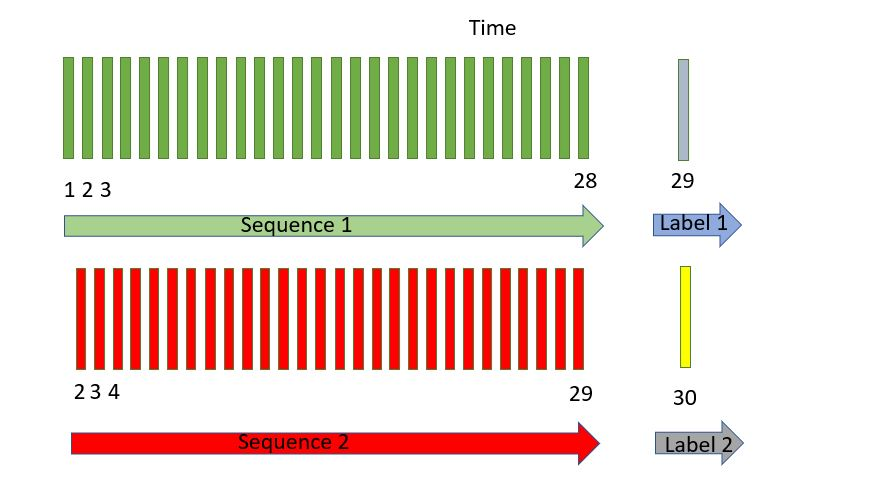

We create a sliding window which builds sequences and labels.
In our case, we have sequences of `WINDOW_SIZE` minutes, that will use to predict the next 15 minutes (from the competition tutorial).

**The Time series modeling framework:**

* Fill gaps in the training set like it describer in the competition tutorial notebook;
* Use `TimeseriesGenerator` like generator class to build the dataset;
* Build the model. Simplified  structure:
    - Lambda layer needed for assets separation;
    - Masking layer. Generated records (filled gaps) has zeros as features values, so they are not used in the computations.
    - Our sequence model architecture
    - Concatenation layer
    - Dense layer

Because of the nature of this competition, we will implement the idea of using the parallel sequence model branches. One for for each asset to then use the represenation learned to output a vector of targets for each timestep.



>Credit: Intro and Images are edited from: https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data

____
**Credits:**
The following notebook is heavily based on the following notebooks. If you find it useful, spare some upvotes to the originals. They earned it! 
- "[G-Research] Parallel LSTM training"  by DEVOLNYX - https://www.kaggle.com/vmuzhichenko/g-research-parallel-lstm-training

____

# LGBM pipeline

Ref:

**Credits:**
The following notebook is heavily based on the following notebooks. If you find it useful, spare some upvotes to the originals. They earned it!

* __[G-Research: LGBM pipeline Notebook](https://www.kaggle.com/julian3833/g-research-starter-lgbm-pipeline) (notebook)__

## Training with LGBM

In [ ]:
from lightgbm import LGBMRegressor
import gresearch_crypto

In [ ]:
# Two new features from the competition tutorial
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
# It works for rows to, so we can reutilize it.
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    return df_feat

def get_Xy_and_model_for_asset(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    # TODO: Try different features here!
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    y = df_proc["y"]
    
    # TODO: Try different models here!
    model = LGBMRegressor(n_estimators=10)
    model.fit(X, y)
    return X, y, model

In [ ]:
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(asset_details['Asset_ID'], asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y, model = get_Xy_and_model_for_asset(crypto_df_train, asset_id)    
    Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model

In [ ]:
# Check the model interface
x = get_features(crypto_df_train.iloc[1])
y_pred = models[0].predict([x])
y_pred[0]

In [ ]:
all_df_test = []

env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        
        model = models[row['Asset_ID']]
        x_test = get_features(row)
        y_pred = model.predict([x_test])[0]
        
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
        
        
        # Print just one sample row to get a feeling of what it looks like
        if i == 0 and j == 0:
            display(x_test)

    # Display the first prediction dataframe
    if i == 0:
        display(df_pred)
    all_df_test.append(df_test)

    # Send submissions
    env.predict(df_pred)